# Chapter 3: Your First GAN

In [9]:
%matplotlib inline

import matplotlib.pyplot as plt
import numpy as np


from tensorflow.keras.datasets import mnist
from tensorflow.keras.layers import Dense, Flatten, Reshape, Conv2D
from tensorflow.keras.layers import LeakyReLU
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam


In [10]:
img_rows = 28
img_cols = 28
channels = 1

# Input image dimensions
img_shape = (img_rows, img_cols, channels)

# Size of the noise vector, used as input to the Generator
z_dim = 100

## Generator

In [11]:
def build_generator(img_shape, z_dim):
    model = Sequential()

    # Fully connected layer
    model.add(Dense(7 * 7 * 128, input_dim=z_dim))
    model.add(Reshape((7, 7, 128)))
    model.add(LeakyReLU(alpha=0.2))

    # Transposed convolutional layers
    model.add(Conv2DTranspose(64, kernel_size=(3, 3), strides=(2, 2), padding='same'))
    model.add(LeakyReLU(alpha=0.2))

    model.add(Conv2DTranspose(1, kernel_size=(3, 3), strides=(2, 2), padding='same', activation='tanh'))

    return model


## Discriminator

In [12]:
def build_discriminator(img_shape):
    model = Sequential()

    # Convolutional layers
    model.add(Conv2D(64, kernel_size=(3, 3), strides=(2, 2), padding='same', input_shape=img_shape))
    model.add(LeakyReLU(alpha=0.2))
    model.add(Dropout(0.25))

    model.add(Conv2D(128, kernel_size=(3, 3), strides=(2, 2), padding='same'))
    model.add(LeakyReLU(alpha=0.2))
    model.add(Dropout(0.25))

    model.add(Flatten())

    # Output layer with sigmoid activation
    model.add(Dense(1, activation='sigmoid'))

    return model


## Build the Model

In [13]:
def build_gan(generator, discriminator):
    model = Sequential()
    model.add(generator)
    model.add(discriminator)
    return model


In [ ]:
from tensorflow.keras.layers import Conv2DTranspose, Dropout

# Build and compile the Discriminator
discriminator = build_discriminator(img_shape)
discriminator.compile(loss='binary_crossentropy',
                      optimizer=Adam(),
                      metrics=['accuracy'])

# Build the Generator
generator = build_generator(img_shape, z_dim)

# Keep Discriminator’s parameters constant for Generator training
discriminator.trainable = False

# Build and compile GAN model with fixed Discriminator to train the Generator
gan = build_gan(generator, discriminator)
gan.compile(loss='binary_crossentropy', optimizer=Adam())


## Training

In [15]:
losses = []
accuracies = []
iteration_checkpoints = []


def train(iterations, batch_size, sample_interval):

    # Load the MNIST dataset
    (X_train, _), (_, _) = mnist.load_data()

    # Rescale [0, 255] grayscale pixel values to [-1, 1]
    X_train = X_train / 127.5 - 1.0
    X_train = np.expand_dims(X_train, axis=3)

    # Labels for real images: all ones
    real = np.ones((batch_size, 1))

    # Labels for fake images: all zeros
    fake = np.zeros((batch_size, 1))

    for iteration in range(iterations):

        # -------------------------
        #  Train the Discriminator
        # -------------------------

        # Get a random batch of real images
        idx = np.random.randint(0, X_train.shape[0], batch_size)
        imgs = X_train[idx]

        # Generate a batch of fake images
        z = np.random.normal(0, 1, (batch_size, 100))
        gen_imgs = generator.predict(z)

        # Train Discriminator
        d_loss_real = discriminator.train_on_batch(imgs, real)
        d_loss_fake = discriminator.train_on_batch(gen_imgs, fake)
        d_loss, accuracy = 0.5 * np.add(d_loss_real, d_loss_fake)

        # ---------------------
        #  Train the Generator
        # ---------------------

        # Generate a batch of fake images
        z = np.random.normal(0, 1, (batch_size, 100))
        gen_imgs = generator.predict(z)

        # Train Generator
        g_loss = gan.train_on_batch(z, real)

        if (iteration + 1) % sample_interval == 0:

            # Save losses and accuracies so they can be plotted after training
            losses.append((d_loss, g_loss))
            accuracies.append(100.0 * accuracy)
            iteration_checkpoints.append(iteration + 1)

            # Output training progress
            print("%d [D loss: %f, acc.: %.2f%%] [G loss: %f]" %
                  (iteration + 1, d_loss, 100.0 * accuracy, g_loss))

            # Output a sample of generated image
            sample_images(generator)

In [16]:
def sample_images(generator, image_grid_rows=4, image_grid_columns=4):

    # Sample random noise
    z = np.random.normal(0, 1, (image_grid_rows * image_grid_columns, z_dim))

    # Generate images from random noise
    gen_imgs = generator.predict(z)

    # Rescale image pixel values to [0, 1]
    gen_imgs = 0.5 * gen_imgs + 0.5

    # Set image grid
    fig, axs = plt.subplots(image_grid_rows,
                            image_grid_columns,
                            figsize=(4, 4),
                            sharey=True,
                            sharex=True)

    cnt = 0
    for i in range(image_grid_rows):
        for j in range(image_grid_columns):
            # Output a grid of images
            axs[i, j].imshow(gen_imgs[cnt, :, :, 0], cmap='gray')
            axs[i, j].axis('off')
            cnt += 1

## Train the GAN and Inspect Output

Note that the `'Discrepancy between trainable weights and collected trainable'` warning from Keras is expected. It is by design: The Generator's trainable parameters are intentionally held constant during Discriminator training, and vice versa.

11493376/11490434 [==============================] - 1s 0us/step


2023-06-17 08:50:17.494428: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:116] None of the MLIR optimization passes are enabled (registered 2)
2023-06-17 08:50:17.514851: I tensorflow/core/platform/profile_utils/cpu_utils.cc:112] CPU Frequency: 2400005000 Hz
2023-06-17 08:50:17.714151: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcublas.so.11
2023-06-17 08:50:18.760181: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcublasLt.so.11
2023-06-17 08:50:18.768504: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcudnn.so.8


1000 [D loss: 0.309433, acc.: 87.11%] [G loss: 3.477316]
2000 [D loss: 0.458607, acc.: 78.12%] [G loss: 2.061468]
3000 [D loss: 0.448779, acc.: 79.69%] [G loss: 1.719728]
4000 [D loss: 0.530727, acc.: 74.61%] [G loss: 1.280358]
5000 [D loss: 0.503944, acc.: 74.61%] [G loss: 1.417452]
6000 [D loss: 0.524136, acc.: 72.27%] [G loss: 1.425365]
7000 [D loss: 0.504013, acc.: 73.83%] [G loss: 1.400252]
8000 [D loss: 0.531439, acc.: 74.22%] [G loss: 1.341908]
9000 [D loss: 0.422916, acc.: 79.30%] [G loss: 1.582509]
10000 [D loss: 0.613503, acc.: 66.80%] [G loss: 1.409246]
11000 [D loss: 0.492620, acc.: 76.56%] [G loss: 1.477777]
12000 [D loss: 0.487173, acc.: 76.95%] [G loss: 1.491246]
13000 [D loss: 0.431500, acc.: 78.91%] [G loss: 1.563617]
14000 [D loss: 0.540579, acc.: 73.83%] [G loss: 1.436574]
15000 [D loss: 0.480847, acc.: 76.95%] [G loss: 1.408477]
16000 [D loss: 0.453745, acc.: 77.34%] [G loss: 1.559052]
17000 [D loss: 0.537508, acc.: 73.05%] [G loss: 1.464412]
18000 [D loss: 0.532537

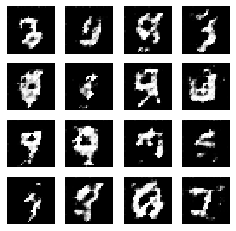

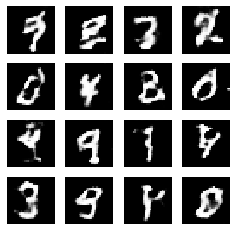

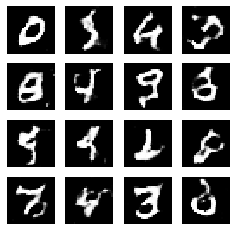

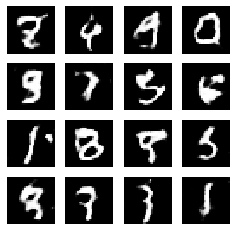

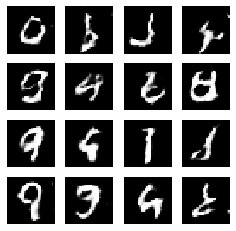

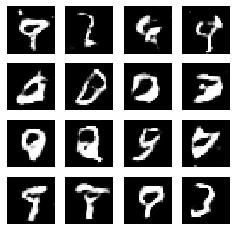

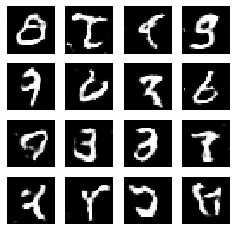

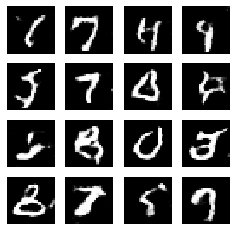

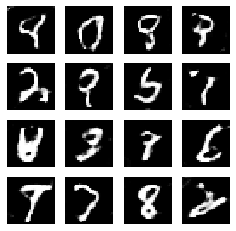

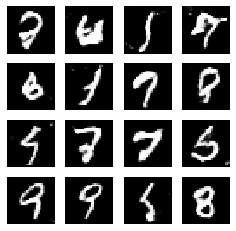

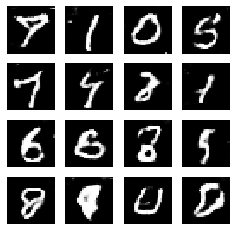

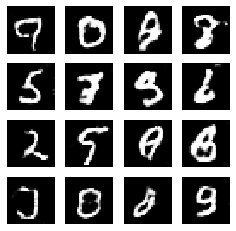

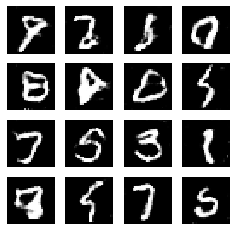

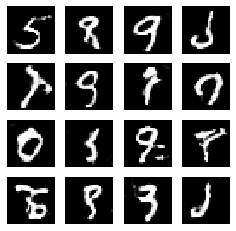

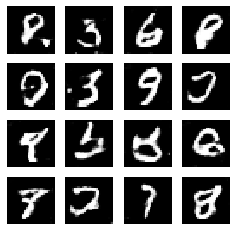

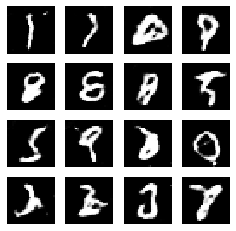

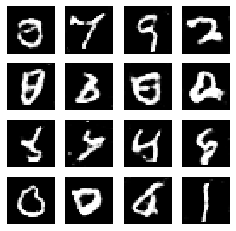

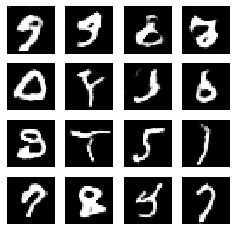

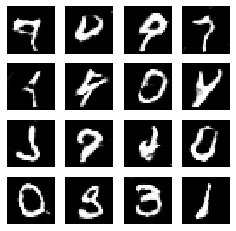

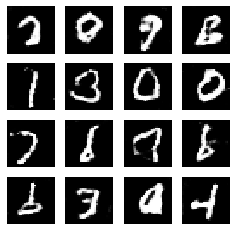

In [17]:
# Set hyperparameters
iterations = 20000
batch_size = 128
sample_interval = 1000

# Train the GAN for the specified number of iterations
train(iterations, batch_size, sample_interval)

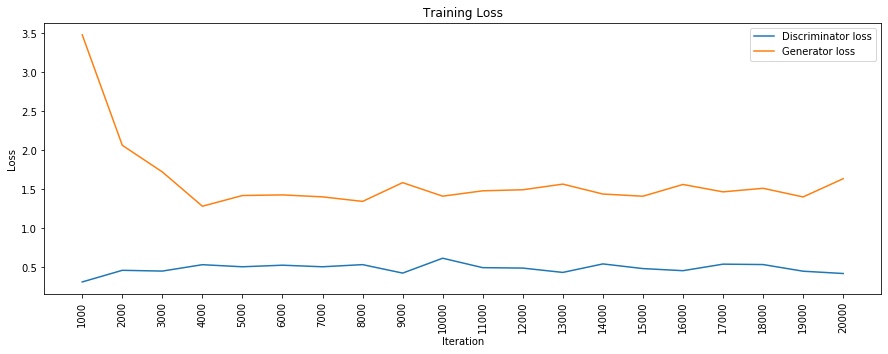

In [18]:
losses = np.array(losses)

# Plot training losses for Discriminator and Generator
plt.figure(figsize=(15, 5))
plt.plot(iteration_checkpoints, losses.T[0], label="Discriminator loss")
plt.plot(iteration_checkpoints, losses.T[1], label="Generator loss")

plt.xticks(iteration_checkpoints, rotation=90)

plt.title("Training Loss")
plt.xlabel("Iteration")
plt.ylabel("Loss")
plt.legend()

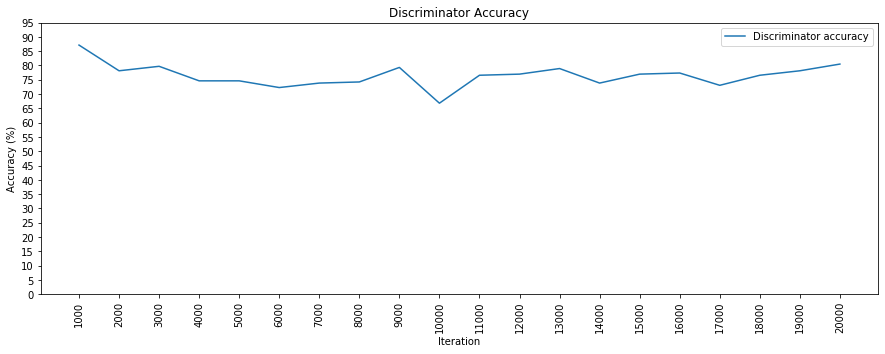

In [19]:
accuracies = np.array(accuracies)

# Plot Discriminator accuracy
plt.figure(figsize=(15, 5))
plt.plot(iteration_checkpoints, accuracies, label="Discriminator accuracy")

plt.xticks(iteration_checkpoints, rotation=90)
plt.yticks(range(0, 100, 5))

plt.title("Discriminator Accuracy")
plt.xlabel("Iteration")
plt.ylabel("Accuracy (%)")
plt.legend()

----